In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('ddos_attack_log.csv')
df

,Timestamp,Source IP,Attack Type,Total Packets,Total Bytes
0,2024-10-18 14:33:29,152.58.203.2,SYN flood,1,60
1,2024-10-18 14:33:29,31.33.105.44,SYN flood,3,60
2,2024-10-18 14:33:29,147.154.203.84,SYN flood,5,60
3,2024-10-18 14:33:29,204.125.179.166,SYN flood,7,60
4,2024-10-18 14:33:29,69.171.60.103,SYN flood,9,60
...,...,...,...,...,...
681,2024-10-18 14:33:40,192.168.132.128,Smurf,118,7080
682,2024-10-18 14:33:40,192.168.132.128,Smurf,119,7140
683,2024-10-18 14:33:40,192.168.132.128,Smurf,120,7200
684,2024-10-18 14:33:40,192.168.132.128,Smurf,121,7260


In [3]:
import requests
import time
import pandas as pd

# Function to get the country for a given IP address using an external API
def get_country(ip):
    try:
        response = requests.get(f'http://ip-api.com/json/{ip}')  # Send a request to the API
        data = response.json()  # Parse the JSON response
        return data.get('country', 'Unknown')  # Return the country or 'Unknown' if not found
    except requests.RequestException:
        return 'Error'  # Return 'Error' if there's a request exception

# Function to get country information with a delay to avoid hitting the API too quickly
def get_country_with_delay(ip):
    time.sleep(1)  # Introduce a 1-second delay
    return get_country(ip)  # Call the get_country function

start_time = time.time()  # Record the start time for processing
df['Country'] = df['Source IP'].apply(get_country_with_delay)  # Apply the function to get countries for each IP
end_time = time.time()  # Record the end time for processing

print(f"Processing time: {end_time-start_time:.2f} seconds")  # Print the total processing time


Processing time: 765.44 seconds


In [4]:
df

,Timestamp,Source IP,Attack Type,Total Packets,Total Bytes,Country
0,2024-10-18 14:33:29,152.58.203.2,SYN flood,1,60,India
1,2024-10-18 14:33:29,31.33.105.44,SYN flood,3,60,France
2,2024-10-18 14:33:29,147.154.203.84,SYN flood,5,60,Germany
3,2024-10-18 14:33:29,204.125.179.166,SYN flood,7,60,United States
4,2024-10-18 14:33:29,69.171.60.103,SYN flood,9,60,United States
...,...,...,...,...,...,...
681,2024-10-18 14:33:40,192.168.132.128,Smurf,118,7080,Unknown
682,2024-10-18 14:33:40,192.168.132.128,Smurf,119,7140,Unknown
683,2024-10-18 14:33:40,192.168.132.128,Smurf,120,7200,Unknown
684,2024-10-18 14:33:40,192.168.132.128,Smurf,121,7260,Unknown


In [5]:
# This line saves the pandas DataFrame df to a new CSV file
df.to_csv('ddos_attack_log_with_countries.csv', index=False)

In [44]:
# Counting attacks from different countries
df['Country'].value_counts()

Country
Unknown          233
United States    175
China             44
Japan             23
Germany           22
                ... 
Indonesia          1
Sweden             1
Malaysia           1
Romania            1
Iran               1
Name: count, Length: 67, dtype: int64

# Where are the suspect IP addresses located?

In [20]:
countries = df['Country'].value_counts()  # Count occurrences of each country in the 'Country' column
countries_df = countries.reset_index()  # Convert the Series to a DataFrame and reset the index
countries_df.columns = ['Country', 'Count']  # Rename columns to 'Country' and 'Count'
countries_df = countries_df.iloc[1:].reset_index(drop=True)  # Remove the first row (typically an 'Unknown' or similar entry) and reset the index
countries_df  # Display the final DataFrame

,Country,Count
0,United States,175
1,China,44
2,Japan,23
3,Germany,22
4,Canada,15
...,...,...
61,Indonesia,1
62,Sweden,1
63,Malaysia,1
64,Romania,1


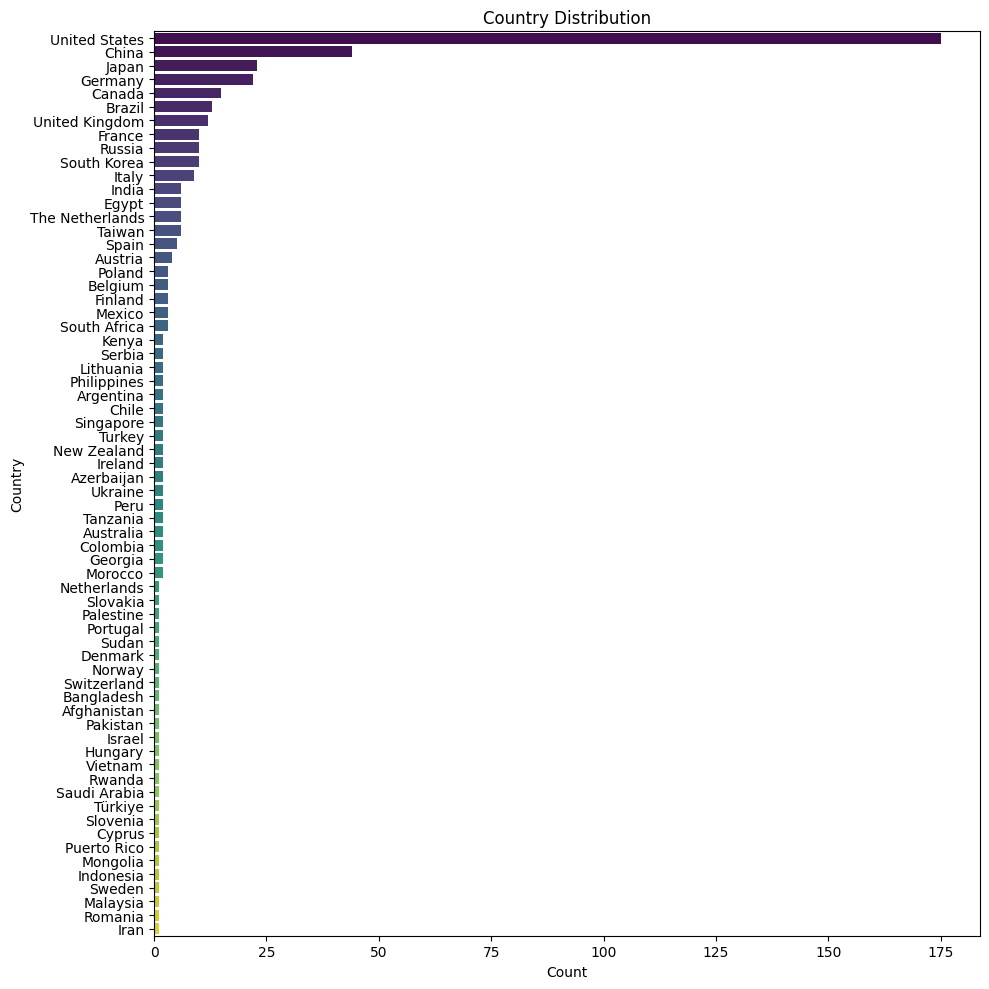

In [25]:
plt.figure(figsize=(10, 10))
sns.barplot(x='Count', y='Country', hue='Country', data=countries_df, palette='viridis', legend=False)

plt.title('Country Distribution')
plt.xlabel('Count')
plt.ylabel('Country')

plt.tight_layout()
plt.show()

# What is the attack that generated more packets?

In [26]:
# Group the DataFrame by 'Attack Type' and sum the 'Total Packets' for each type
attack_packets = df.groupby('Attack Type')['Total Packets'].sum().reset_index()  

# Find the row with the maximum value in the 'Total Packets' column
max_attack = attack_packets.loc[attack_packets['Total Packets'].idxmax()]  

# Output the attack type with the highest total packets
print(max_attack)  


Attack Type      SYN-ACK flood
Total Packets            30701
Name: 2, dtype: object


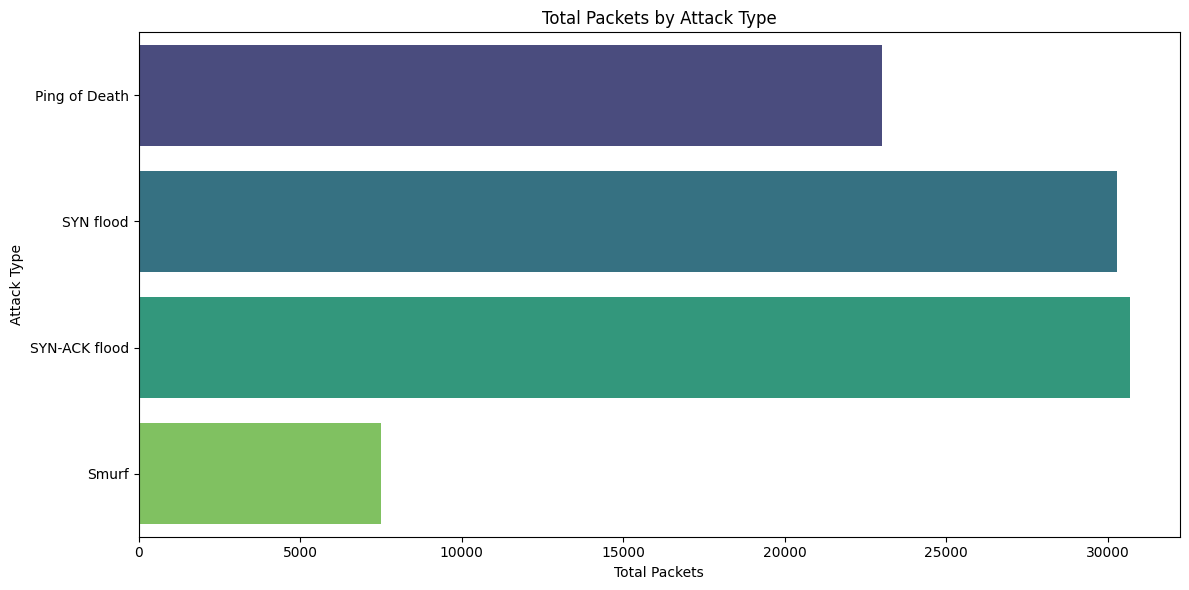

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Total Packets', y='Attack Type', hue='Attack Type', data=attack_packets, palette='viridis', legend=False)

plt.title('Total Packets by Attack Type')
plt.xlabel('Total Packets')
plt.ylabel('Attack Type')

plt.tight_layout()
plt.show()

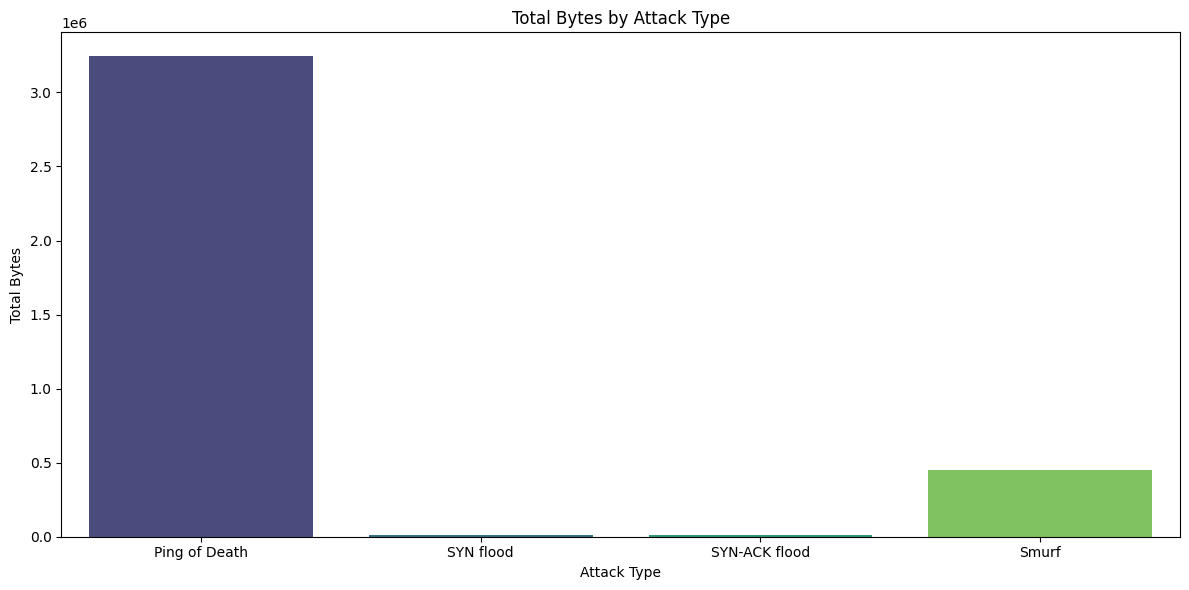

Attack with the largest traffic in bytes: Ping of Death, Bytes: 3243746


In [31]:
attack_traffic = df.groupby('Attack Type')['Total Bytes'].sum().reset_index()

max_traffic_attack = attack_traffic.loc[attack_traffic['Total Bytes'].idxmax()]

plt.figure(figsize=(12, 6))
sns.barplot(x='Attack Type', y='Total Bytes', data=attack_traffic, palette='viridis', hue='Attack Type', legend=False)

plt.title('Total Bytes by Attack Type')
plt.xlabel('Attack Type')
plt.ylabel('Total Bytes')

plt.tight_layout()
plt.show()

print(f'Attack with the largest traffic in bytes: {max_traffic_attack["Attack Type"]}, Bytes: {max_traffic_attack["Total Bytes"]}')

# What is the attack that generated the largest traffic in terms of bytes? And in bytes per second?

In [36]:
bytes_per_second_df = df[['Timestamp', 'Attack Type', 'Total Bytes']]
bytes_per_second_df

,Timestamp,Attack Type,Total Bytes
0,2024-10-18 14:33:29,SYN flood,60
1,2024-10-18 14:33:29,SYN flood,60
2,2024-10-18 14:33:29,SYN flood,60
3,2024-10-18 14:33:29,SYN flood,60
4,2024-10-18 14:33:29,SYN flood,60
...,...,...,...
681,2024-10-18 14:33:40,Smurf,7080
682,2024-10-18 14:33:40,Smurf,7140
683,2024-10-18 14:33:40,Smurf,7200
684,2024-10-18 14:33:40,Smurf,7260


     Attack Type  Total_Bytes  Bytes_per_Second
0  Ping of Death      3243746        16218730.0
1      SYN flood        10440           52200.0
2  SYN-ACK flood        10560           52800.0
3          Smurf       450180         2250900.0


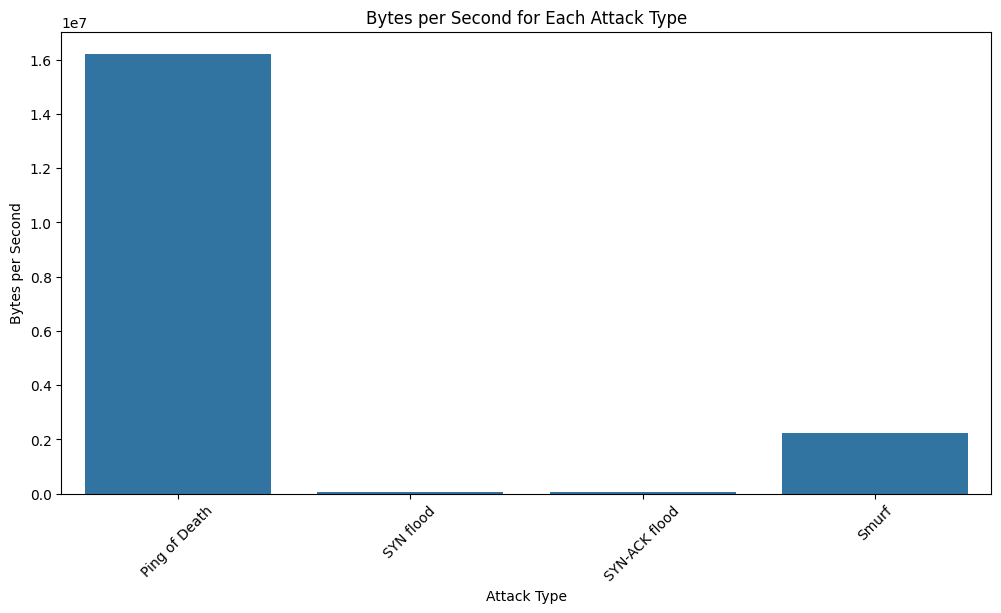

In [43]:
# Convert the 'Timestamp' column to datetime format for proper time handling
bytes_per_second_df.loc[:, 'Timestamp'] = pd.to_datetime(bytes_per_second_df['Timestamp'])

# Summarize total bytes by attack type
attack_summary = (bytes_per_second_df
                  .groupby('Attack Type')  # Group by 'Attack Type'
                  .agg(Total_Bytes=('Total Bytes', 'sum'))  # Sum 'Total Bytes' for each attack type
                  .reset_index())  # Reset index to convert the result back to a DataFrame

# Define duration in seconds for calculating bytes per second (I initiated the DDoS procedure for just 0.2 seconds.)
duration = 0.2

# Calculate bytes per second for each attack type
attack_summary['Bytes_per_Second'] = attack_summary['Total_Bytes'] / duration

# Output the attack summary DataFrame
print(attack_summary)

# Set up the figure for the bar plot
plt.figure(figsize=(12, 6))

# Create a bar plot for bytes per second by attack type
sns.barplot(data=attack_summary, x='Attack Type', y='Bytes_per_Second')

# Add titles and labels to the plot
plt.title('Bytes per Second for Each Attack Type')
plt.xlabel('Attack Type')
plt.ylabel('Bytes per Second')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()
